# Figure 5: Radial Comparison

Comparison between PSP, Solar Orbiter, MMS, and Wind (1AU) measurements.

- Panel (a): $M_A$
- Panel (b): $\sigma_C$
- Panel (c): $v_R$ [km/s]
- Panel (d): $B_r R^2$ [nT]
- Panel (e): $N_P R^2$ [cm^{-3}]
- Panel (f): $\beta$
- Panel (g): Trajectories (lon/lat) [deg]

In [94]:
import glob
import pyspedas
from pyspedas import time_string, time_double
from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
import sunpy 
import sunpy.coordinates as scoords
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from scipy import stats


import sys, os
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

import tools.utilities as utils
import tools.sigma as sigma
import tools.psp_funcs as psp_funcs
import tools.pfss_funcs as pfss_funcs
from tools.plotting import plot_pfss
from tools.settings import CsvDir, ImgDir, PlotDir, DataDir
import matplotlib.ticker as ticker


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from datetime import timedelta

for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# REGIONS
loc_hcs = [61.8, 62.2]
loc_hcs1 = [357, 358.8]
ssw = [9, 19]
fsw = [42, 52]

# COLORS
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']

# DIRECTORIES
RES_DIR = os.path.realpath('results')
FIG_DIR = os.path.realpath('figures')
EPS_DIR = os.path.realpath('eps_figures')
OBS_DIR = '/Users/tamarervin/products/csv_files/calcs/'
PlotDir = '/Users/tamarervin/mplstyle/'


# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
plt.rcParams['axes.linewidth'] = 5

enc='E15'


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

20-Dec-23 15:04:00: /Users/tamarervin/miniconda3/envs/e11_conjunction/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## Read in Data

In [178]:
### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

### UPDATE WIND DATAFRAME ###
wind['MA'] = np.abs(wind.MA)
wind['vr'] = np.abs(wind.vr)
wind['sigmac'] = -1*wind.sigmac
winddownt = utils.time_resample([wind])[0]
winddownt['Time'] = winddownt.index
winddownl = utils.lon_bin(wind, vv='sslon')

20-Dec-23 16:05:20: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:169: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

20-Dec-23 16:05:20: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:169: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

20-Dec-23 16:05:24: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:178: FutureWarning: 'loffset' 

In [3]:
plon = utils.rollto180(np.array(parkerdownl.sslon)*u.deg)
olon = utils.rollto180(np.array(orbiterdownl.sslon)*u.deg)
wlon = utils.rollto180(np.array(winddownl.sslon)*u.deg)

# Trajectories

## Parker and Orbiter

In [92]:
dt_start,dt_end = datetime.datetime(2023,3,15),datetime.datetime(2023,4,3)
def gen_dt_arr(dt_init,dt_final,cadence_days=1) :
    """
    Get array of datetime.datetime from {dt_init} to {dt_final} every 
    {cadence_days} days
    """
    dt_list = []
    while dt_init < dt_final :
        dt_list.append(dt_init)
        dt_init += datetime.timedelta(days=cadence_days)
    return np.array(dt_list)

### GENERATE TIME ARRAYS
dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)
ts_common = np.array([dt.timestamp() for dt in dt_common])

### GENERATE VELOCITY ARRAYS
psp_vr_common = interp1d(np.array([dt.timestamp() for dt in parker.Time]),parker.vr,bounds_error=False)(ts_common)*u.km/u.s
solo_vr_common = interp1d(np.array([dt.timestamp() for dt in orbiter.Time]),orbiter.vr,bounds_error=False)(ts_common)*u.km/u.s

In [95]:
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dt_common
)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

### Create SkyCoord for SolO in the inertial (J2000) frame
solo_inertial = astrospice.generate_coords(
    'Solar Orbiter',dt_common
)
### Transform to solar co-rotating frame 
solo_carrington = solo_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

In [98]:
# Functions from https://github.com/STBadman/PSP_E10_Sources/blob/main/helpers.py

@u.quantity_input
def delta_long(r:u.R_sun,
               r_inner=2.5*u.R_sun,
               vsw=360.*u.km/u.s,
               omega_sun=14.713*u.deg/u.d,
               ):
    """ 
    Ballistic longitudinal shift of a Parker spiral connecting two
    points at radius r and r_inner, for a solar wind speed vsw. Solar
    rotation rate is also tunable
    """
    return (omega_sun * (r - r_inner) / vsw).to("deg")

def ballistically_project(skycoord,r_inner = 2.5*u.R_sun, vr_arr=None) :
    """
    Given a `SkyCoord` of a spacecraft trajectory in the Carrington frame,
    with `representation_type="spherical"`, and optionally an array of
    measured solar wind speeds at the same time intervals of the trajectory,
    return a SkyCoord for the trajectory ballistically projected down to 
    `r_inner` via a Parker spiral of the appropriate curvature. When `vr_arr`
    is not supplied, assumes wind speed is everywhere 360 km/s
    """
    if vr_arr is None : vr_arr = np.ones(len(skycoord))*360*u.km/u.s
    lons_shifted = skycoord.lon + delta_long(skycoord.radius,
                                             r_inner=r_inner,
                                             vsw=vr_arr
                                            )
    return SkyCoord(
        lon = lons_shifted, 
        lat = skycoord.lat,
        radius = r_inner * np.ones(len(skycoord)),
        representation_type="spherical",
        frame = skycoord.frame
    )

In [99]:
psp_projected = ballistically_project(psp_carrington,vr_arr=psp_vr_common)
solo_projected = ballistically_project(solo_carrington,vr_arr=solo_vr_common)

In [100]:
def parker_streamline(phi0=0.0*u.deg,
                      r0=1.0*u.R_sun,
                      w_s=(2.*np.pi)/(24.47*(24*3600))*u.rad/u.s,
                      v_sw=360*u.km/u.s,
                      rmax=215*u.R_sun,
                      sampling=500,
                     ) :
    """Starting from an inner polar coordinatate ({r0},{phi0}), trace
    a ballistic spiral out to {rmax} with curvature set by a solar wind
    speed of {v_sw} with {sampling} gridpoints
    """
    # Output r :: Rs, phi :: deg
    r = np.linspace(r0,rmax,sampling)
    phi = -w_s/v_sw*(r-r0) + phi0
    return r.to("R_sun"),phi.to("deg")

In [101]:
psp_streamlines = [
    parker_streamline(
        phi0=projected_coord.lon,
        r0 = projected_coord.radius,
        v_sw = v)
    for projected_coord,v in zip(psp_projected,psp_vr_common)]
solo_streamlines = [
    parker_streamline(
        phi0=projected_coord.lon,
        r0 = projected_coord.radius,
        v_sw = v)
    for projected_coord,v in zip(solo_projected,solo_vr_common)]

## Wind Trajectory

In [154]:
wind_carrington = SkyCoord(np.array(wind.lon)*u.deg, np.array(wind.lat)*u.deg, np.array(wind.rAU)*u.AU, frame= sunpy.coordinates.HeliographicCarrington, representation_type='spherical', obstime=np.array(wind.Time))
wind_carrington.obstime

<Time object: scale='utc' format='datetime64' value=['2023-03-16T00:00:05.982000000' '2023-03-16T00:01:37.982000000'
 '2023-03-16T00:03:09.982000000' ... '2023-03-31T23:56:53.842000000'
 '2023-03-31T23:58:25.842000000' '2023-03-31T23:59:57.842000000']>

## MMS Trajectory

In [5]:
### MMS Composition Data
mms = pd.read_csv('results/mms.csv')
mms['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in mms.Time]
mms.columns

Index(['Unnamed: 0', 'Time', 'hpvx', 'hpvy', 'hpvz', 'hpN', 'hepN', 'heppN',
       'opN', 'hpP', 'Tp', 'B', 'Bx', 'By', 'Bz', 'vr', 'vt', 'vn', 'Br', 'Bt',
       'Bn', 'Np', 'sigmac', 'sigmar', 'vA', 'Zp', 'Zm', 'deltav', 'deltab',
       'MA', 'betap', 'Pm', 'Pp'],
      dtype='object')

In [31]:
### MMS Bow Shock Crossings
bowshock = pd.read_csv('results/bowShockCrossings.txt', sep=', ', index_col=None)
bowshock['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in bowshock.Time]
inbound = bowshock.iloc[np.where(bowshock=='IB')[0]].copy()
outbound = bowshock.iloc[np.where(bowshock=='OB')[0]].copy()

### MMS Magnetosphere Events
magnetosphere = pd.read_csv('results/magnetosphereEventList.txt', sep=', ', index_col=None)
magnetosphere['TimeIn'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in magnetosphere.TimeIn]
magnetosphere['TimeOut'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in magnetosphere.TimeOut]


20-Dec-23 13:20:29: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_1991/1567417083.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  bowshock = pd.read_csv('results/bowShockCrossings.txt', sep=', ', index_col=None)

20-Dec-23 13:20:29: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_1991/1567417083.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  magnetosphere = pd.read_csv('results/magnetosphereEventList.txt', sep=', ', index_col=None)



In [122]:
files = np.sort(glob.glob(os.path.join(os.path.realpath(os.path.join('pydata/mms1/mec/srvy/l2/epht89q/2023/03/', "*"))), recursive=True))
import cdflib
time, Xgse, Ygse, Zgse = [], [], [], []
# coords, tt = [], []
for f in files:
    data_cdf = cdflib.CDF(f) 
    ### READ IN VARIABLE INFO
    time.extend((cdflib.cdfepoch.to_datetime(data_cdf.varget("Epoch"))))
    Xgse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 0]))
    Ygse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 1]))
    Zgse.extend((data_cdf.varget("mms1_mec_r_gse")[:, 2]))

    # ### READ IN VARIABLE INFO
    # time = cdflib.cdfepoch.to_datetime(data_cdf.varget("Epoch"))
    # Xgse = data_cdf.varget("mms1_mec_r_gse")[:, 0]
    # Ygse = data_cdf.varget("mms1_mec_r_gse")[:, 1]
    # Zgse = data_cdf.varget("mms1_mec_r_gse")[:, 2]


    ### ADD TO LIST
    # tt.append(time)
    # coords.append(mms_carrington)

In [124]:
### TRANSFORM TO HELIOGRAPHIC CARRINGTON
mms1_gse = SkyCoord(np.array(Xgse)*u.km, np.array(Ygse)*u.km, np.array(Zgse)*u.km, frame=sunpy.coordinates.frames.GeocentricSolarEcliptic, representation_type='cartesian', obstime=np.array(time))
mms_carrington = mms1_gse.transform_to(
    scoords.HeliographicCarrington(observer="self"))
mms_carrington.representation_type = 'spherical'

## Figure Test

20-Dec-23 15:42:07: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_1991/4111366523.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()



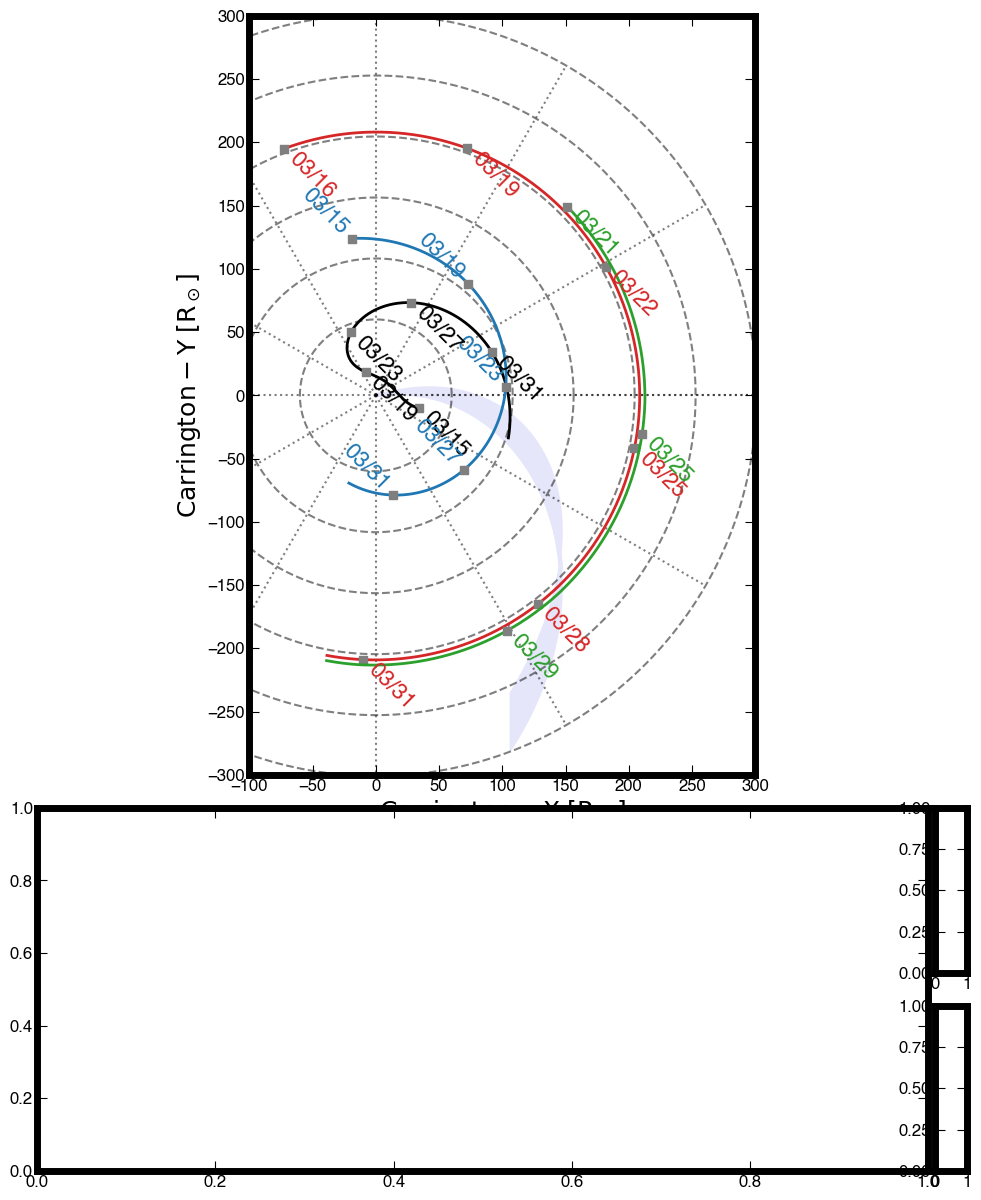

In [156]:
### Set up panels
fig = plt.figure(figsize=(12,15))
gs = plt.GridSpec(6,24,figure=fig)
axes = np.array(
    [fig.add_subplot(gs[0:4,:]),
     fig.add_subplot(gs[4:,0:23]),
     fig.add_subplot(gs[4,-1]),
     fig.add_subplot(gs[5,-1])
    ]
)
days=4
cp, cs, ca, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
### TOP PANEL ####

### TRAJECTORIES AND DATES
label_cadence = 48*days 

### PARKER
psp_carrington.representation_type="cartesian"
axes[0].plot(
    psp_carrington.x.to("R_sun"),
    psp_carrington.y.to("R_sun"),
    color=cp,linewidth=2,label="PSP",zorder=10
)
axes[0].scatter(
    psp_carrington.x.to("R_sun")[::label_cadence],
    psp_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### ORBITER
solo_carrington.representation_type="cartesian"
axes[0].plot(
    solo_carrington.x.to("R_sun"),
    solo_carrington.y.to("R_sun"),
    color=cs,linewidth=2,label="Solar Orbiter",zorder=10
)
axes[0].scatter(
    solo_carrington.x.to("R_sun")[::label_cadence],
    solo_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### WIND
wc=720*days
wind_carrington.representation_type="cartesian"
axes[0].plot(
    wind_carrington.x.to("R_sun"),
    wind_carrington.y.to("R_sun"),
    color=ca,linewidth=2,label="Wind",zorder=10
)
axes[0].scatter(
    wind_carrington.x.to("R_sun")[::wc],
    wind_carrington.y.to("R_sun")[::wc],
    color=dcol, marker='s',zorder=10
)

### MMS
mc=2880*days
mms_carrington.representation_type="cartesian"
axes[0].plot(
    mms_carrington.x.to("R_sun"),
    mms_carrington.y.to("R_sun"),
    color=cm,linewidth=2,label="MMS",zorder=10
)
axes[0].scatter(
    mms_carrington.x.to("R_sun")[::mc],
    mms_carrington.y.to("R_sun")[::mc],
    color=dcol, marker='s',zorder=10
)

### LABEL DATES
for dt,pspc,soc in zip(dt_common[::label_cadence],
                       psp_carrington[::label_cadence],
                       solo_carrington[::label_cadence]) :
    axes[0].text(pspc.x.to("R_sun").value,
                 pspc.y.to("R_sun").value,
                f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cp,
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    axes[0].text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cs,
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )
for dt, wsc in zip(wind_carrington.obstime.datetime[::wc],
                    wind_carrington[::wc]):
    axes[0].text(wsc.x.to("R_sun").value,
                    wsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=ca,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )
for dt, mmsc in zip(mms_carrington.obstime.datetime[::mc],
                    mms_carrington[::mc]):
    axes[0].text(mmsc.x.to("R_sun").value,
                    mmsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cm,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )


### SHADE SA STREAM
parker1 = parker_streamline(
        phi0= ssw[0]*u.deg,
        r0 = 2.5*u.R_sun,
        rmax = 300*u.R_sun ,
        v_sw=450*u.km/u.s
    )
axes[0].plot(parker[0]*np.cos(parker[1]),
            parker[0]*np.sin(parker[1]),
            color=scol,linewidth=3,zorder=-1
           ) 
parker2 = parker_streamline(
        phi0= ssw[1]*u.deg,
        r0 = 2.5*u.R_sun,
        rmax = 300*u.R_sun ,
        v_sw=500*u.km/u.s
    )
axes[0].plot(parker[0]*np.cos(parker[1]),
            parker[0]*np.sin(parker[1]),
            color =scol,linewidth=3,zorder=-1
           ) 
axes[0].fill_between((parker1[0]*np.cos(parker1[1])).value,
            (parker1[0]*np.sin(parker1[1])).value,
            (parker2[0]*np.sin(parker2[1])).value,
            color=scol,zorder=-1
           ) 


### Gridlines / Axis Lables ETC for axes[0]
axes[0].set_aspect(1)
rmax=300
rgrids = np.linspace(60, rmax+1, 6)
for R_ in rgrids  :
    axes[0].plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
            R_*np.sin(np.linspace(0,2*np.pi,300)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=rmax    
for phi in np.radians(np.linspace(0,360,13)) :
    axes[0].plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
axes[0].set_xticks(np.linspace(-300,300,13))
axes[0].set_yticks(np.linspace(-300,300,13))
axes[0].set_xlim([-100,300])
axes[0].set_ylim([-300,300])
axes[0].set_xlabel(r"$\rm Carrington-X \; [R_\odot]$", fontsize=18)
axes[0].set_ylabel(r"$\rm Carrington-Y \; [R_\odot]$", fontsize=18)

plt.tight_layout()


# Figure 5: Radial Comparison

Show propagation of stream from Parker to Orbiter to MMS to Wind! Want to look at velocity, density, magnetic field, trajectory.

- Panel (a): Mach Number
- Panel (b): Cross Helicity
- Panel (c): Radial Velocity
- Panel (d): Radial Magnetic Field
- Panel (e): Proton Density
- Panel (f): Plasma Beta
- Panel (g): Trajectories

20-Dec-23 15:58:42: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


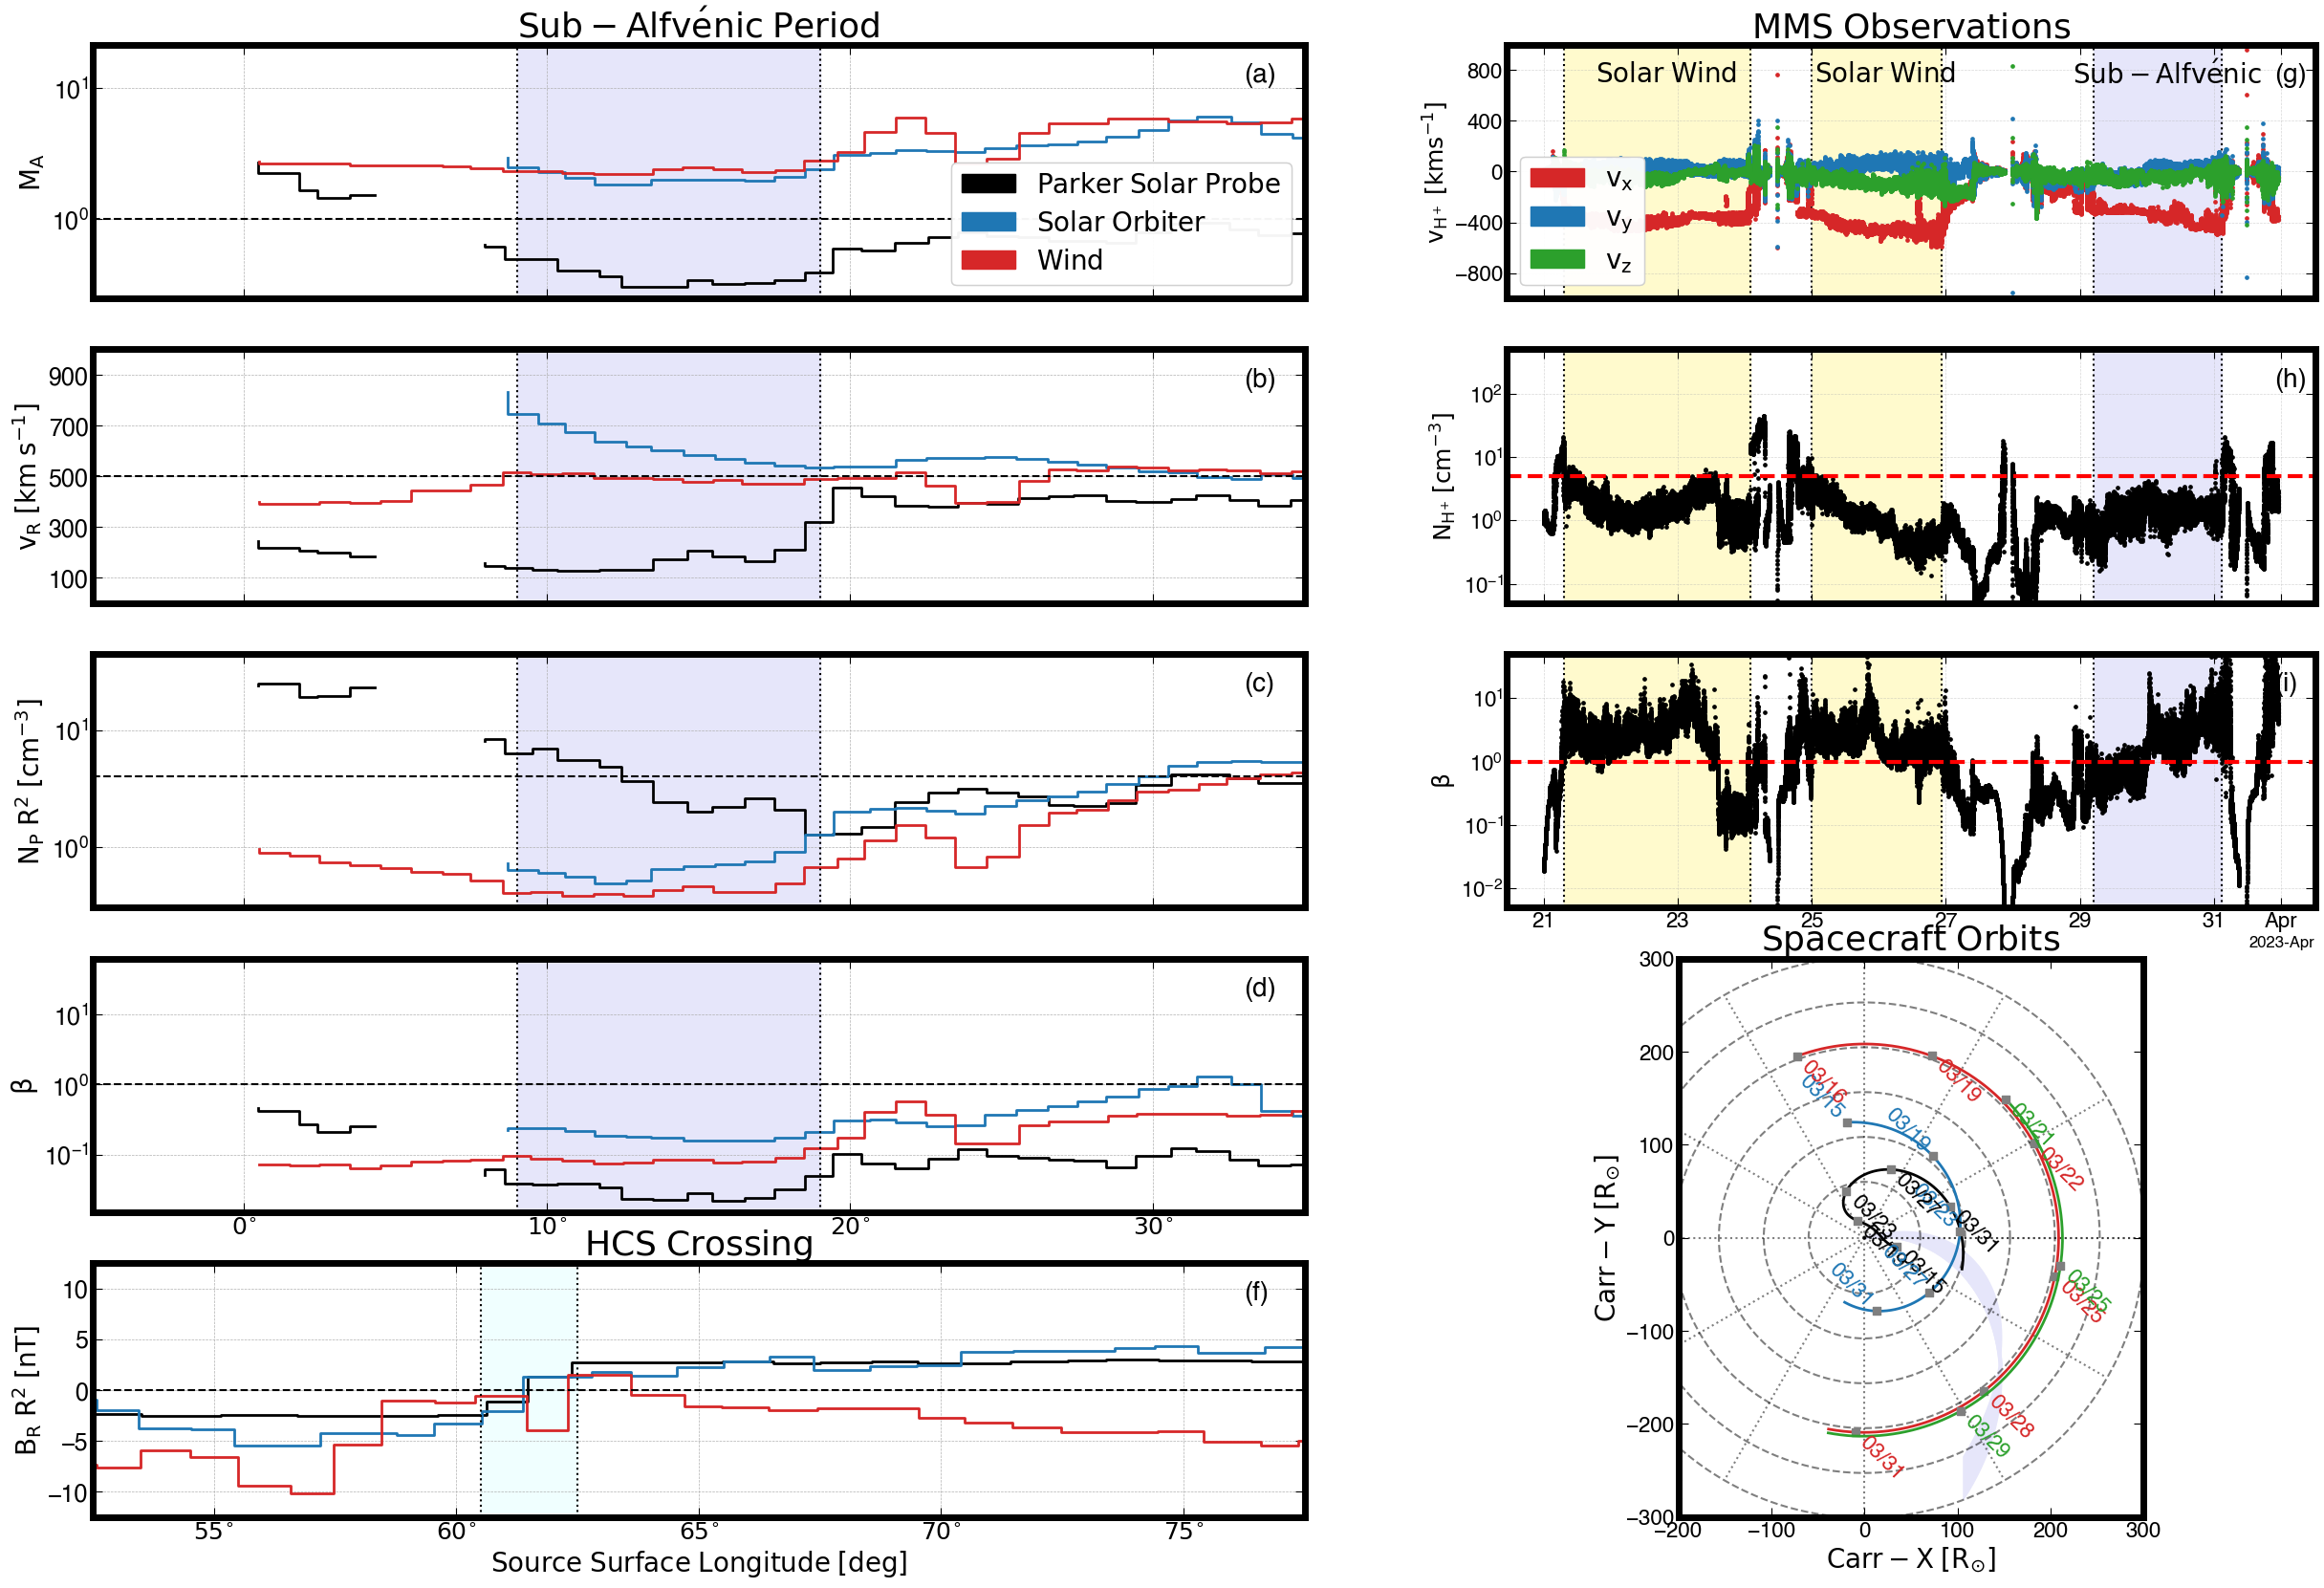

In [175]:
##### ------------------------------------------------------ ######
              ##### ---------- SETUP  ---------- ######
##### ------------------------------------------------------ ######
fig = plt.figure(figsize=(30, 20))
gs = plt.GridSpec(5, 2, width_ratios=[3, 2])

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm M_A$', ### Mach number
            r'$\rm v_R \; [km \; s^{-1}]$', ### radial velocity
            r'$\rm N_P \; R^2 \; [cm^{-3}]$', ### proton density
            r'$\rm \beta$', ### plasma beta
            # r'$\rm Source \; Surface$' + '\n' + r'$\rm Latitude \; [deg]$', ### trajectory
            r'$\rm B_R \; R^2 \;  [nT]$',  ### radial magnetic field
            ]

### DEFINE DATA, LABELS, COLORMAPS
data = ['MA', 'vr', 'NpR2', 'beta'] #, 'sslat']
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
rcol='grey'
lw = 2
cp, cs, ca, cm = ['black', 'tab:blue', 'tab:red', 'tab:green']

##### ------------------------------------------------------------ ######
##### ---------- LEFT COLUMN (PARKER, ORBITER, WIND)  ---------- ######
##### ------------------------------------------------------------ ######
axs = [plt.subplot(gs[i, 0]) for i in np.arange(0, 4)]
axs[0].set_title(r'$\rm Sub-Alfv\'enic \; Period$', fontsize=26)

##### ---------- PARKER DATA  ---------- ######
for i, vv in enumerate(data):

    if i == 4:
    ### PLOT THE TRAJECTORY
        axs[i].scatter(parkerdownl.sslon, parkerdownl[vv], c=cp, s=25, edgecolor='k', linewidth=0.5, zorder=2)
        axs[i].scatter(orbiterdownl.sslon, orbiterdownl[vv], c=cs, s=25, edgecolor='k', linewidth=0.5, zorder=2)
        axs[i].scatter(winddownl.sslon, winddownl[vv], c=ca, s=25, edgecolor='k', linewidth=0.5, zorder=2)
        axs[i].text(5, 1, r"$\rm Parker \; (03/16-17)$",fontsize=20,weight="bold",rotation=0, c='k')
        axs[i].annotate(None,(25,0),(15,0),arrowprops=dict(color='k', width=1.5))
        axs[i].text(2, -3.5, r"$\rm Solar \; Orbiter \; (03/23)$",fontsize=20, weight="bold", c='tab:blue')
        axs[i].annotate(None,(5,-4.5),(15,-4.5),arrowprops=dict(color='tab:blue', width=1.5))
        axs[i].text(20, -5.75, r"$\rm Wind \; (03/26-29)$",fontsize=20, weight="bold", c='tab:red')
        axs[i].annotate(None,(20,-6.25),(35,-6.25),arrowprops=dict(color='tab:red', width=1.5))
    else:
    ### PLOT THE DATA
        axs[i].step(parkerdownl.sslon, parkerdownl[vv], c=cp, linewidth=lw, zorder=2)
        axs[i].step(orbiterdownl.sslon, orbiterdownl[vv], c=cs, linewidth=lw, zorder=2)
        axs[i].step(winddownl.sslon, winddownl[vv], c=ca, linewidth=lw, zorder=2)
        axs[i].set_xticklabels([])

    ### ADD Y-LABEL
    axs[i].set_ylabel(ylabel=ylabels[i], fontsize=20)
    axs[i].tick_params(axis='both', which='major', labelsize=18) 

    ### ADD X-LIMITS
    axs[i].set(xlim=(-5, 35), xticks=np.arange(0, 31, step=10))

    ### ADD THE GRID
    axs[i].grid(True, linestyle='--', linewidth=0.5)

    ### ADD REGIONS ###
    regions = [
        (loc_hcs[0], loc_hcs[1], hcol),
        (loc_hcs1[0], loc_hcs1[1], hcol),
        (ssw[0], ssw[1], scol),
        (fsw[0], fsw[1], fcol)
    ]

    lines = [
        loc_hcs[0],
        loc_hcs[1],
        loc_hcs1[0],
        loc_hcs1[1],
        ssw[0],
        ssw[1],
        fsw[0],
        fsw[1]
    ]

    ### PLOT LINES AND REGIONS ###
    for line in lines:
        axs[i].axvline(line, color='k', linestyle='dotted', zorder=5)

    for region in regions:
        axs[i].axvspan(region[0], region[1], color=region[2], zorder=-3)

    ### ADD PANEL LABELS
    axs[i].text(0.95, 0.93, panel_labels[i], transform=axs[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### X TICK LABELS
axs[i].set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 10^{\circ}$', r'$\rm 20^{\circ}$', r'$\rm 30^{\circ}$'], fontsize=18)

### AXES AND TICK MARKS ###
ytick_log = [0.01, 0.1, 1.0, 10, 100]
ylab_log = [str(val) for val in ytick_log]
axs[0].set_yscale('log') ## mach number
axs[1].set(ylim=(0, 1000), yticks=np.arange(100, 901, step=200)) ## radial velocity
axs[2].set_yscale('log') ## proton density
axs[3].set_yscale('log') ## plasma beta
# axs[4].set(ylim=(-10.5, 4.5), yticks=np.arange(-9, 3.1, step=3)) ## latitude

### PLOT MARKINGS ###
axs[0].axhline(1, color='k', linestyle='dashed') ## mach number
# axs[1].axhline(0.9, color='k', linestyle='dashed') ## cross helicity
# axs[1].axhline(-0.9, color='k', linestyle='dashed') ## cross helicity
axs[1].axhline(500, color='k', linestyle='dashed') ## radial velocity
# axs[3].axhline(0, color='k', linestyle='dashed') ## radial magnetic field
axs[2].axhline(4, color='k', linestyle='dashed') ## proton density
axs[3].axhline(1, color='k', linestyle='dashed') ## plasma beta

### LEGEND ###
psp = mpatches.Patch(color=cp,  label= r'$\rm Parker \; Solar \; Probe$')
solo = mpatches.Patch(color=cs,  label= r'$\rm Solar \; Orbiter$')
acep = mpatches.Patch(color=ca,  label= r'$\rm Wind$')
leg0 = axs[0].legend(handles=[psp, solo, acep], loc='lower right', fontsize=20)
axs[0].add_artist(leg0)


##### ------------------------------------------------------------ ######
            ##### ---------- LEFT COLUMN (HCS)  ---------- ######
##### ------------------------------------------------------------ ######
vv, ax = 'BrR2', plt.subplot(gs[i+1, 0])
ax.set_title(r'$\rm HCS \; Crossing$', fontsize=26)

### DATA
ax.step(parkerdownl.sslon, parkerdownl[vv], c=cp, linewidth=lw, zorder=2)
ax.step(orbiterdownl.sslon, orbiterdownl[vv], c=cs, linewidth=lw, zorder=2)
ax.step(winddownl.sslon, winddownl[vv], c=ca, linewidth=lw, zorder=2)

### LABELS
ax.set(xlim=(52.5, 77.5), xticks=np.arange(55, 76, step=5), ylim=(-12.5, 12.5), yticks=np.arange(-10, 10.1, step=5))
ax.set_xticklabels([r'$\rm 55^{\circ}$', r'$\rm 60^{\circ}$', r'$\rm 65^{\circ}$', r'$\rm 70^{\circ}$', r'$\rm 75^{\circ}$'], fontsize=18)
ax.set_xlabel(r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=20)
ax.axhline(0, color='k', linestyle='dashed') ## radial magnetic field
ax.set_ylabel(ylabel=ylabels[-1], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.text(0.95, 0.93, panel_labels[5], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### PLOT LINES AND REGIONS 
ax.axvline(60.5, color='k', linestyle='dotted', zorder=5)
ax.axvline(62.5, color='k', linestyle='dotted', zorder=5)
ax.axvspan(60.5, 62.5, color=hcol, zorder=-3)
ax.grid(True, linestyle='--', linewidth=0.5)

##### ------------------------------------------------------ ######
        ##### ---------- RIGHT COLUMN (MMS)  ---------- ######
##### ------------------------------------------------------ ######
ss, swc = 2, 'lemonchiffon'
axs = [plt.subplot(gs[i, 1]) for i in np.arange(0, 3)]
axs[0].set_title(r'$\rm MMS \; Observations$', fontsize=26)
ylabels = [r'$\rm v_{H^+} \; [km s^{-1}]$', r'$\rm N_{H^{+}} \; [cm^{-3}]$', r'$\rm \beta$']

### REGIONS
regions = [# (magnetosphere.TimeOut[1], magnetosphere.TimeIn[2], swc), 
            (magnetosphere.TimeOut[8], magnetosphere.TimeIn[12], swc), 
            (magnetosphere.TimeOut[3], magnetosphere.TimeIn[5], swc),
            (magnetosphere.TimeOut[18], magnetosphere.TimeIn[20], scol)]

lines = [# magnetosphere.TimeOut[1], magnetosphere.TimeIn[2], 
            magnetosphere.TimeOut[8], magnetosphere.TimeIn[12], 
            magnetosphere.TimeOut[3], magnetosphere.TimeIn[5],
            magnetosphere.TimeOut[18], magnetosphere.TimeIn[20]]

### LABELS 
ax = axs[0]
ax.text(0.11, 0.93, r'$\rm Solar \; Wind$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.38, 0.93, r'$\rm Solar \; Wind$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.70, 0.94, r'$\rm Sub-Alfv\'enic$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

#### ------ PANEL ONE: PROTON VELOCITY ------ ####
ax = axs[0]

### DATA ###
ax.scatter(mms.Time, mms.hpvx, c='tab:red', lw=lw, label=r'$\rm v_x$', s=ss)
ax.scatter(mms.Time, mms.hpvy, c='tab:blue', lw=lw, label=r'$\rm v_y$', s=ss)
ax.scatter(mms.Time, mms.hpvz, c='tab:green', lw=lw, label=r'$\rm v_z$', s=ss)

### LEGEND ###
R_patch = mpatches.Patch(color='tab:red', label=r'$\rm v_x$')
T_patch = mpatches.Patch(color='tab:blue', label=r'$\rm v_y$')
N_patch = mpatches.Patch(color='tab:green', label=r'$\rm v_z$')
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)

### AXES LABELS ###
ax.set(ylim=(-1000, 1000), yticks=np.arange(-800, 801, step=400))
ax.set_ylabel(ylabels[0], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(g)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])

#### ------ PANEL TWO: PROTON DENSITY ------ ####
ax = axs[1]

### DATA ###
ax.scatter(mms.Time, mms.hpN, c='k', lw=lw, label=r'$\rm N_P$', s=ss)

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[1], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axhline(5, color='red', linestyle='dashed', lw=3)
ax.set(ylim=(5e-2, 5e2), yticks=[1e-1, 1e0, 1e1, 1e2])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(h)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xticklabels([])

#### ------ PANEL THREE: BETA ------ ####
ax = axs[2]
### DATA ###
ax.scatter(mms.Time, mms.betap, c='k', lw=lw, label=r'$\rm \beta_P$', s=ss)

### AXES LABELS ###
ax.set_yscale('log')
ax.set_ylabel(ylabels[2], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.axhline(1, color='red', linestyle='dashed', lw=3)
ax.set(ylim=(5e-3, 5e1), yticks=[1e-2, 1e-1, 1e0, 1e1])

### SHADE SOLAR WIND PORTIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=-2)
for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, '(i)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

##### ------------------------------------------------------ ######
    ##### ---------- RIGHT COLUMN (ORBITS)  ---------- ######
##### ------------------------------------------------------ ######
ax = plt.subplot(gs[3:, 1])
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.set_title(r'$\rm Spacecraft \; Orbits$', fontsize=26)
ax.set_xlabel(r'$\rm Carr-X \; [R_{\odot}]$', fontsize=20)
ax.set_ylabel(r'$\rm Carr-Y \; [R_{\odot}]$', fontsize=20)

days=4
cp, cs, ca, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
### TOP PANEL ####

### TRAJECTORIES AND DATES
label_cadence = 48*days 

### PARKER
psp_carrington.representation_type="cartesian"
ax.plot(
    psp_carrington.x.to("R_sun"),
    psp_carrington.y.to("R_sun"),
    color=cp,linewidth=2,label="PSP",zorder=10
)
ax.scatter(
    psp_carrington.x.to("R_sun")[::label_cadence],
    psp_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### ORBITER
solo_carrington.representation_type="cartesian"
ax.plot(
    solo_carrington.x.to("R_sun"),
    solo_carrington.y.to("R_sun"),
    color=cs,linewidth=2,label="Solar Orbiter",zorder=10
)
ax.scatter(
    solo_carrington.x.to("R_sun")[::label_cadence],
    solo_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### WIND
wc=720*days
wind_carrington.representation_type="cartesian"
ax.plot(
    wind_carrington.x.to("R_sun"),
    wind_carrington.y.to("R_sun"),
    color=ca,linewidth=2,label="Wind",zorder=10
)
ax.scatter(
    wind_carrington.x.to("R_sun")[::wc],
    wind_carrington.y.to("R_sun")[::wc],
    color=dcol, marker='s',zorder=10
)

### MMS
mc=2880*days
mms_carrington.representation_type="cartesian"
ax.plot(
    mms_carrington.x.to("R_sun"),
    mms_carrington.y.to("R_sun"),
    color=cm,linewidth=2,label="MMS",zorder=10
)
ax.scatter(
    mms_carrington.x.to("R_sun")[::mc],
    mms_carrington.y.to("R_sun")[::mc],
    color=dcol, marker='s',zorder=10
)

### LABEL DATES
for dt,pspc,soc in zip(dt_common[::label_cadence],
                       psp_carrington[::label_cadence],
                       solo_carrington[::label_cadence]) :
    ax.text(pspc.x.to("R_sun").value,
                 pspc.y.to("R_sun").value,
                f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cp,
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    ax.text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cs,
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )
for dt, wsc in zip(wind_carrington.obstime.datetime[::wc],
                    wind_carrington[::wc]):
    ax.text(wsc.x.to("R_sun").value,
                    wsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=ca,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )
for dt, mmsc in zip(mms_carrington.obstime.datetime[::mc],
                    mms_carrington[::mc]):
    ax.text(mmsc.x.to("R_sun").value,
                    mmsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cm,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )


### SHADE SA STREAM
parker1 = parker_streamline(
        phi0= ssw[0]*u.deg,
        r0 = 2.5*u.R_sun,
        rmax = 300*u.R_sun ,
        v_sw=450*u.km/u.s
    )
ax.plot(parker[0]*np.cos(parker[1]),
            parker[0]*np.sin(parker[1]),
            color=scol,linewidth=3,zorder=-1
           ) 
parker2 = parker_streamline(
        phi0= ssw[1]*u.deg,
        r0 = 2.5*u.R_sun,
        rmax = 300*u.R_sun ,
        v_sw=500*u.km/u.s
    )
ax.plot(parker[0]*np.cos(parker[1]),
            parker[0]*np.sin(parker[1]),
            color =scol,linewidth=3,zorder=-1
           ) 
ax.fill_between((parker1[0]*np.cos(parker1[1])).value,
            (parker1[0]*np.sin(parker1[1])).value,
            (parker2[0]*np.sin(parker2[1])).value,
            color=scol,zorder=-1
           ) 


### Gridlines / Axis Lables ETC for axes[0]
ax.set_aspect(1)
rmax=300
rgrids = np.linspace(60, rmax+1, 6)
for R_ in rgrids  :
    ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
            R_*np.sin(np.linspace(0,2*np.pi,300)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=rmax    
for phi in np.radians(np.linspace(0,360,13)) :
    ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
ax.set_xticks(np.linspace(-300,300,7))
ax.set_yticks(np.linspace(-300,300,7))
ax.set_xlim([-200,300])
ax.set_ylim([-300,300])

plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig5b.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig5b.eps')), bbox_inches='tight')

## Two Column Part 2

20-Dec-23 16:23:45: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


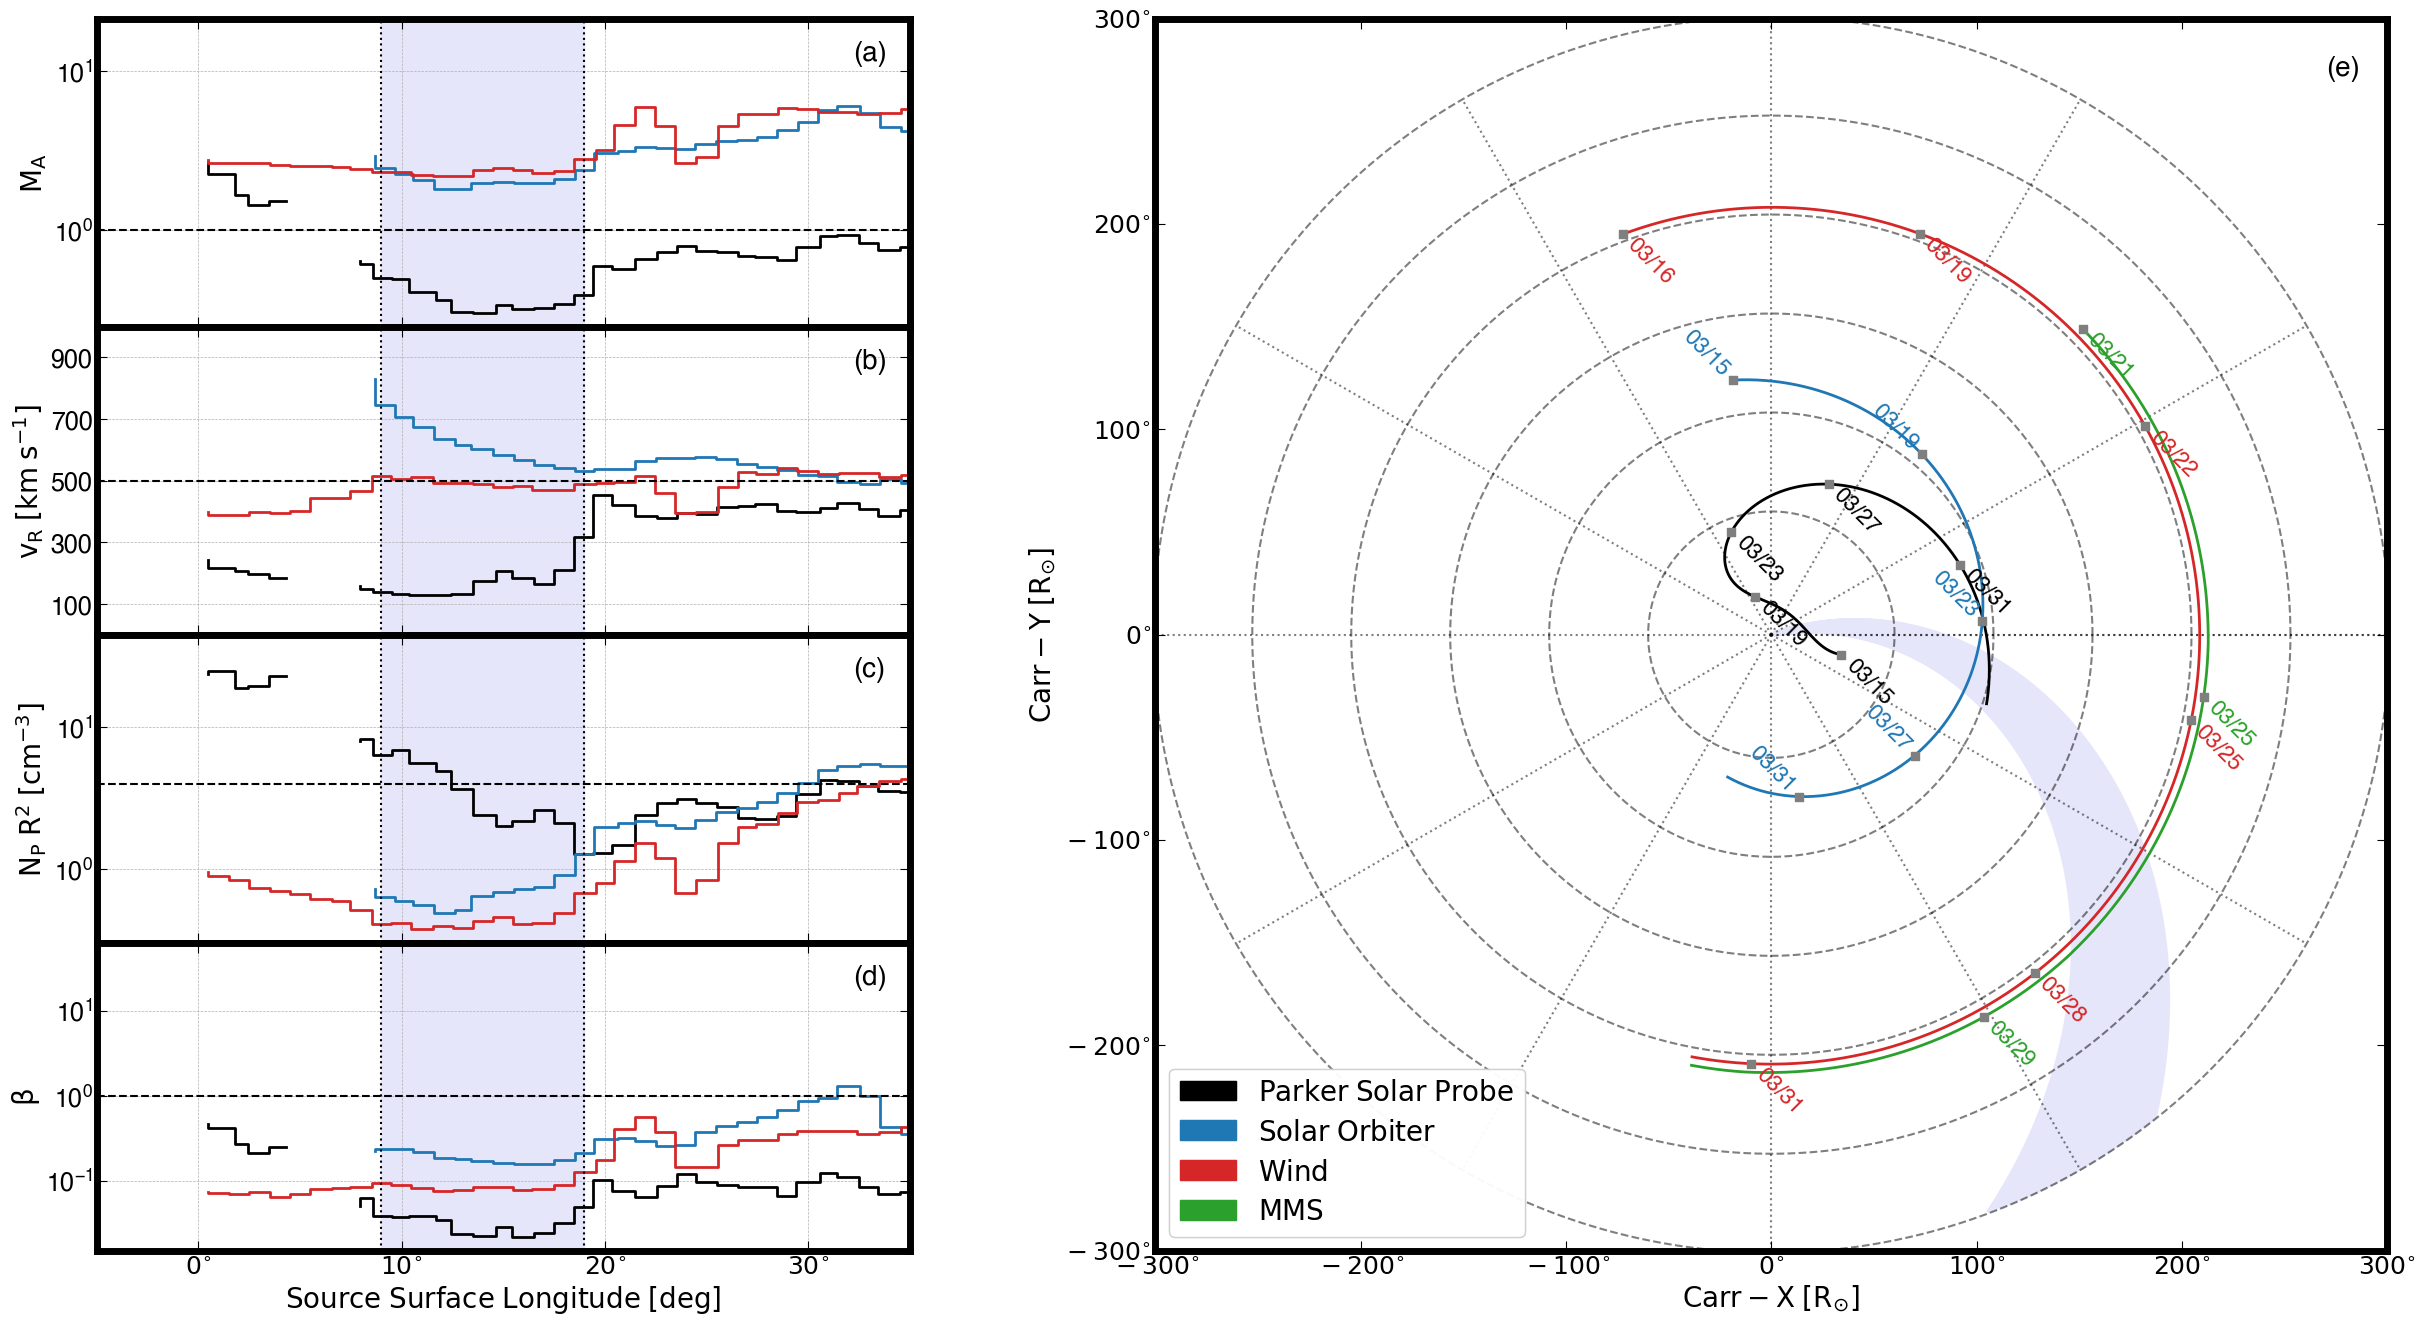

In [201]:
##### ------------------------------------------------------ ######
              ##### ---------- SETUP  ---------- ######
##### ------------------------------------------------------ ######
fig = plt.figure(figsize=(30, 16))
gs = plt.GridSpec(4, 2, width_ratios=[2.5, 4], hspace=0)

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm M_A$', ### Mach number
            r'$\rm v_R \; [km \; s^{-1}]$', ### radial velocity
            r'$\rm N_P \; R^2 \; [cm^{-3}]$', ### proton density
            r'$\rm \beta$', ### plasma beta
            ]

### DEFINE DATA, LABELS, COLORMAPS
data = ['MA', 'vr', 'NpR2', 'beta'] #, 'sslat']
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
rcol='grey'
lw = 2
cp, cs, ca, cm = ['black', 'tab:blue', 'tab:red', 'tab:green']

##### ------------------------------------------------------------ ######
##### ---------- LEFT COLUMN (PARKER, ORBITER, WIND)  ---------- ######
##### ------------------------------------------------------------ ######
axs = [plt.subplot(gs[i, 0]) for i in np.arange(0, 4)]
# axs[0].set_title(r'$\rm Sub-Alfv\'enic \; Period$', fontsize=26)

##### ---------- PARKER DATA  ---------- ######
for i, vv in enumerate(data):
    ### PLOT THE DATA
    axs[i].step(parkerdownl.sslon, parkerdownl[vv], c=cp, linewidth=lw, zorder=2)
    axs[i].step(orbiterdownl.sslon, orbiterdownl[vv], c=cs, linewidth=lw, zorder=2)
    axs[i].step(winddownl.sslon, winddownl[vv], c=ca, linewidth=lw, zorder=2)
    axs[i].set_xticklabels([])

    ### ADD Y-LABEL
    axs[i].set_ylabel(ylabel=ylabels[i], fontsize=20)
    axs[i].tick_params(axis='both', which='major', labelsize=18) 

    ### ADD X-LIMITS
    axs[i].set(xlim=(-5, 35), xticks=np.arange(0, 31, step=10))

    ### ADD THE GRID
    axs[i].grid(True, linestyle='--', linewidth=0.5)

    ### ADD REGIONS ###
    regions = [
        (loc_hcs[0], loc_hcs[1], hcol),
        (loc_hcs1[0], loc_hcs1[1], hcol),
        (ssw[0], ssw[1], scol),
        (fsw[0], fsw[1], fcol)
    ]

    lines = [
        loc_hcs[0],
        loc_hcs[1],
        loc_hcs1[0],
        loc_hcs1[1],
        ssw[0],
        ssw[1],
        fsw[0],
        fsw[1]
    ]

    ### PLOT LINES AND REGIONS ###
    for line in lines:
        axs[i].axvline(line, color='k', linestyle='dotted', zorder=5)

    for region in regions:
        axs[i].axvspan(region[0], region[1], color=region[2], zorder=-3)

    ### ADD PANEL LABELS
    axs[i].text(0.93, 0.93, panel_labels[i], transform=axs[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### X TICK LABELS
axs[i].set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 10^{\circ}$', r'$\rm 20^{\circ}$', r'$\rm 30^{\circ}$'], fontsize=18)
axs[i].set_xlabel(r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=20)

### AXES AND TICK MARKS ###
ytick_log = [0.01, 0.1, 1.0, 10, 100]
ylab_log = [str(val) for val in ytick_log]
axs[0].set_yscale('log') ## mach number
axs[1].set(ylim=(0, 1000), yticks=np.arange(100, 901, step=200)) ## radial velocity
axs[2].set_yscale('log') ## proton density
axs[3].set_yscale('log') ## plasma beta
# axs[4].set(ylim=(-10.5, 4.5), yticks=np.arange(-9, 3.1, step=3)) ## latitude

### PLOT MARKINGS ###
axs[0].axhline(1, color='k', linestyle='dashed') ## mach number
# axs[1].axhline(0.9, color='k', linestyle='dashed') ## cross helicity
# axs[1].axhline(-0.9, color='k', linestyle='dashed') ## cross helicity
axs[1].axhline(500, color='k', linestyle='dashed') ## radial velocity
# axs[3].axhline(0, color='k', linestyle='dashed') ## radial magnetic field
axs[2].axhline(4, color='k', linestyle='dashed') ## proton density
axs[3].axhline(1, color='k', linestyle='dashed') ## plasma beta


##### ------------------------------------------------------ ######
    ##### ---------- RIGHT COLUMN (ORBITS)  ---------- ######
##### ------------------------------------------------------ ######
ax = plt.subplot(gs[:, 1])
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xlabel(r'$\rm Carr-X \; [R_{\odot}]$', fontsize=20)
ax.set_ylabel(r'$\rm Carr-Y \; [R_{\odot}]$', fontsize=20)
ax.text(0.95, 0.97, '(e)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

days=4
cp, cs, ca, cm, dcol = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:gray']
### TOP PANEL ####

### TRAJECTORIES AND DATES
label_cadence = 48*days 

### PARKER
psp_carrington.representation_type="cartesian"
ax.plot(
    psp_carrington.x.to("R_sun"),
    psp_carrington.y.to("R_sun"),
    color=cp,linewidth=2,label="PSP",zorder=10
)
ax.scatter(
    psp_carrington.x.to("R_sun")[::label_cadence],
    psp_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### ORBITER
solo_carrington.representation_type="cartesian"
ax.plot(
    solo_carrington.x.to("R_sun"),
    solo_carrington.y.to("R_sun"),
    color=cs,linewidth=2,label="Solar Orbiter",zorder=10
)
ax.scatter(
    solo_carrington.x.to("R_sun")[::label_cadence],
    solo_carrington.y.to("R_sun")[::label_cadence],
    color=dcol, marker='s',zorder=10
)

### WIND
wc=720*days
wind_carrington.representation_type="cartesian"
ax.plot(
    wind_carrington.x.to("R_sun"),
    wind_carrington.y.to("R_sun"),
    color=ca,linewidth=2,label="Wind",zorder=10
)
ax.scatter(
    wind_carrington.x.to("R_sun")[::wc],
    wind_carrington.y.to("R_sun")[::wc],
    color=dcol, marker='s',zorder=10
)

### MMS
mc=2880*days
mms_carrington.representation_type="cartesian"
ax.plot(
    mms_carrington.x.to("R_sun"),
    mms_carrington.y.to("R_sun"),
    color=cm,linewidth=2,label="MMS",zorder=10
)
ax.scatter(
    mms_carrington.x.to("R_sun")[::mc],
    mms_carrington.y.to("R_sun")[::mc],
    color=dcol, marker='s',zorder=10
)

### LABEL DATES
for dt,pspc,soc in zip(dt_common[::label_cadence],
                       psp_carrington[::label_cadence],
                       solo_carrington[::label_cadence]) :
    ax.text(pspc.x.to("R_sun").value,
                 pspc.y.to("R_sun").value,
                f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cp,
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    ax.text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cs,
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )
for dt, wsc in zip(wind_carrington.obstime.datetime[::wc],
                    wind_carrington[::wc]):
    ax.text(wsc.x.to("R_sun").value,
                    wsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=ca,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )
for dt, mmsc in zip(mms_carrington.obstime.datetime[::mc],
                    mms_carrington[::mc]):
    ax.text(mmsc.x.to("R_sun").value,
                    mmsc.y.to("R_sun").value,
                    f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color=cm,
                    verticalalignment="top",
                    horizontalalignment="left",zorder=10,fontsize=16
                )


### SHADE SA STREAM
for xx in np.arange(450, 501, step=2):
    for j in np.arange(9, 20, step=2):
        parker1 = parker_streamline(
                phi0= j*u.deg,
                r0 = 2.5*u.R_sun,
                rmax = 300*u.R_sun ,
                v_sw=xx*u.km/u.s
            )
        ax.plot(parker1[0]*np.cos(parker1[1]),
                    parker1[0]*np.sin(parker1[1]),
                    color=scol,linewidth=3,zorder=-1
                ) 


### Gridlines / Axis Lables ETC for axes[0]
ax.set_aspect(1)
rmax=300
rgrids = np.linspace(60, rmax+1, 6)
for R_ in rgrids  :
    ax.plot(R_*np.cos(np.linspace(0,2*np.pi,300)),
            R_*np.sin(np.linspace(0,2*np.pi,300)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=rmax    
for phi in np.radians(np.linspace(0,360,13)) :
    ax.plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
ax.set_xticks(np.linspace(-300,300,7))
ax.set_yticks(np.linspace(-300,300,7))
ax.set_xlim([-300,300])
ax.set_ylim([-300,300])
ax.set_xticklabels([r'$\rm -300^{\circ}$', r'$\rm -200^{\circ}$', r'$\rm -100^{\circ}$', r'$\rm 0^{\circ}$', r'$\rm 100^{\circ}$', r'$\rm 200^{\circ}$', r'$\rm 300^{\circ}$'], fontsize=18)
ax.set_yticklabels([r'$\rm -300^{\circ}$', r'$\rm -200^{\circ}$', r'$\rm -100^{\circ}$', r'$\rm 0^{\circ}$', r'$\rm 100^{\circ}$', r'$\rm 200^{\circ}$', r'$\rm 300^{\circ}$'], fontsize=18)

### LEGEND ###
psp = mpatches.Patch(color=cp,  label= r'$\rm Parker \; Solar \; Probe$')
solo = mpatches.Patch(color=cs,  label= r'$\rm Solar \; Orbiter$')
acep = mpatches.Patch(color=ca,  label= r'$\rm Wind$')
mmsp = mpatches.Patch(color=cm,  label= r'$\rm MMS$')
leg0 = ax.legend(handles=[psp, solo, acep, mmsp], loc='lower left', fontsize=20)
ax.add_artist(leg0)

plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig5.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig5.eps')), bbox_inches='tight')

# Original Figure

19-Dec-23 13:55:10: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


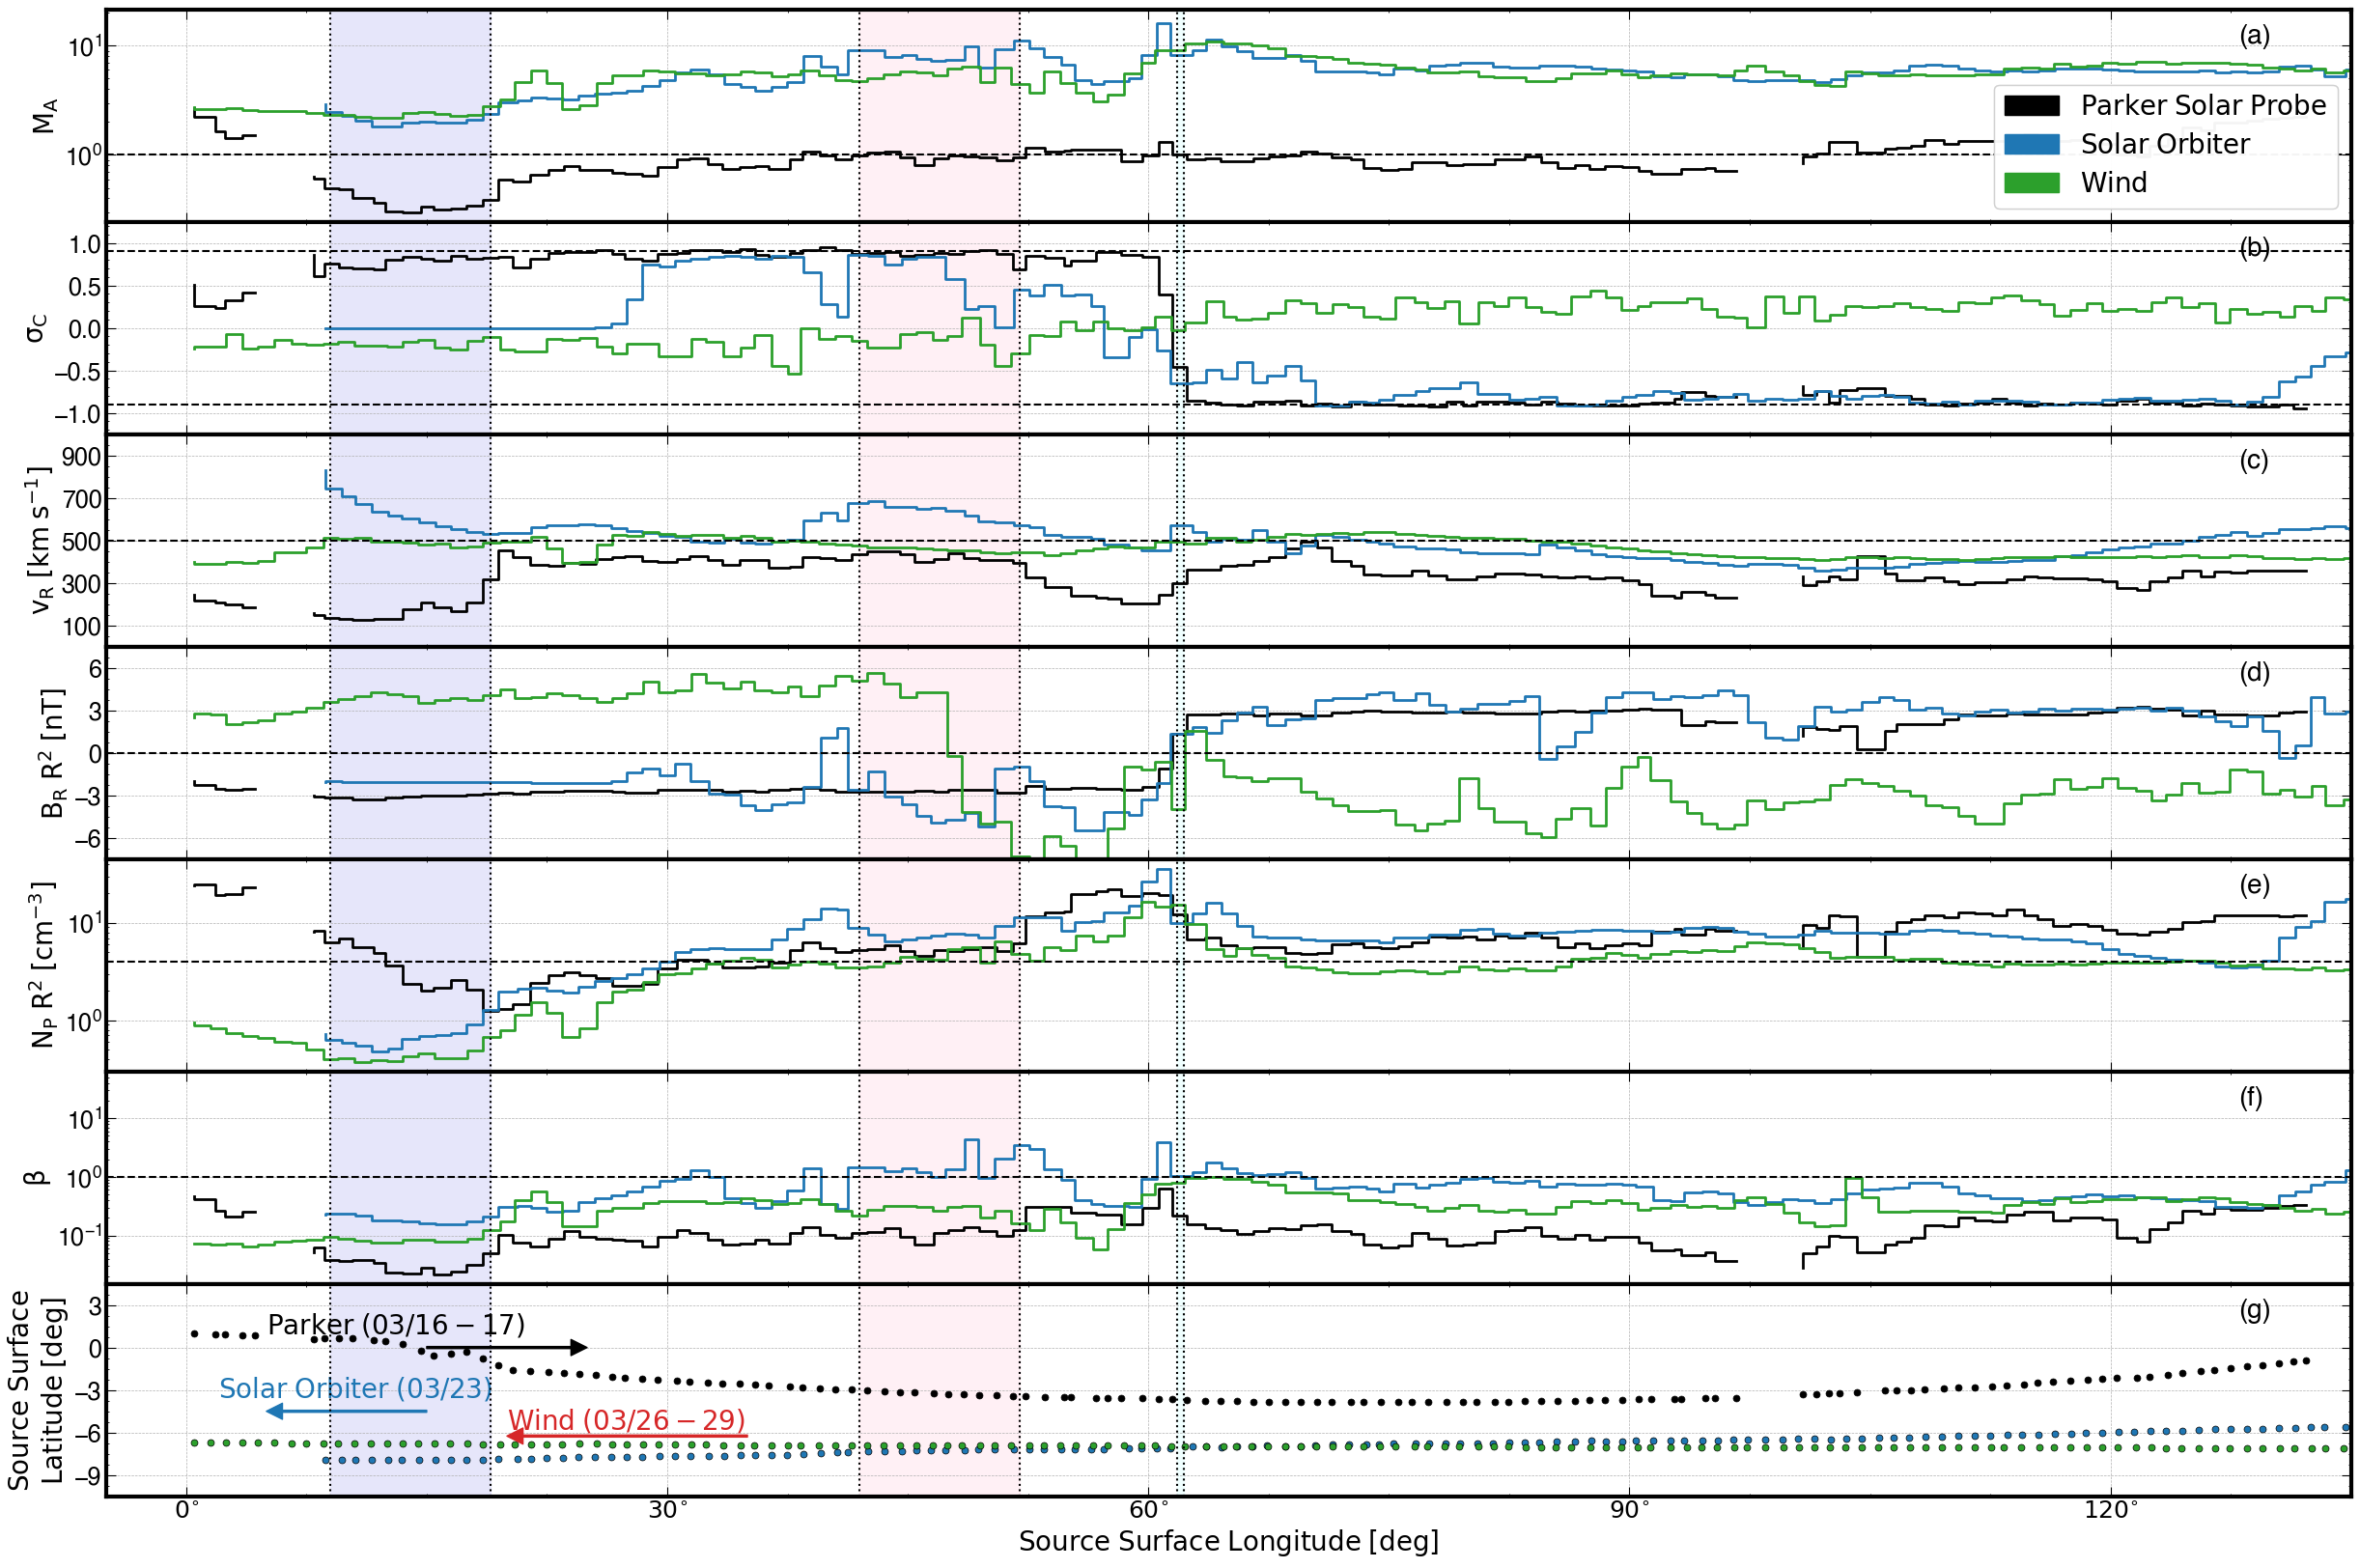

In [7]:
# # PLOT SETUP
# fig = plt.figure(figsize=[30, 20])
# fig.tight_layout()
# plt.rcParams['axes.linewidth'] = 3
# grid = plt.GridSpec(4, 2, hspace=0.27, wspace=0.20, width_ratios=[1, 1, 1], height_ratios=[1, 3, 3, 3])

# ### FIGURE SETUP
# fig = plt.figure(figsize=(30, 30))


# ### CREATE SUBPLOTS
# ax1 = fig.add_subplot(grid[0, 0])


# ### LABELS
# xlabel = r'$\rm Time$'
# ylabels = [r'$\rm M_A$', ### Mach number
#         #    r'$\rm \sigma_C$', ### cross helicity
#             r'$\rm v_R \; [km \; s^{-1}]$', ### radial velocity
#             # r'$\rm B_R \; R^2 \;  [nT]$',  ### radial magnetic field
#             r'$\rm N_P \; R^2 \; [cm^{-3}]$', ### proton density
#             r'$\rm \beta$', ### plasma beta
#             r'$\rm Source \; Surface$' + '\n' + r'$\rm Latitude \; [deg]$' ### trajectory
#             ]

# ### DEFINE DATA, LABELS, COLORMAPS
# data = ['MA', 'vr', 'BrR2', 'NpR2', 'beta', 'sslat'] # 'sigmac', 
# panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
# cmaps = ['spring', 'RdPu', 'cool', 'Wistia', 'coolwarm', 'winter']
# cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']
# rcol='grey'
# lw = 2
# cp, cs, ca, cm = ['black', 'tab:blue', 'tab:red', 'tab:green', 'tab:red']

# ##### ---------- PARKER DATA  ---------- ######
# for i, vv in enumerate(data):

#     if i == 6:
#     ### PLOT THE TRAJECTORY
#         axs[i].scatter(parkerdownl.sslon, parkerdownl[vv], c=cp, s=25, edgecolor='k', linewidth=0.5, zorder=2)
#         axs[i].scatter(orbiterdownl.sslon, orbiterdownl[vv], c=cs, s=25, edgecolor='k', linewidth=0.5, zorder=2)
#         axs[i].scatter(winddownl.sslon, winddownl[vv], c=ca, s=25, edgecolor='k', linewidth=0.5, zorder=2)
#         axs[i].text(5, 1, r"$\rm Parker \; (03/16-17)$",fontsize=20,weight="bold",rotation=0, c='k')
#         axs[i].annotate(None,(25,0),(15,0),arrowprops=dict(color='k', width=1.5))
#         axs[i].text(2, -3.5, r"$\rm Solar \; Orbiter \; (03/23)$",fontsize=20, weight="bold", c='tab:blue')
#         axs[i].annotate(None,(5,-4.5),(15,-4.5),arrowprops=dict(color='tab:blue', width=1.5))
#         axs[i].text(20, -5.75, r"$\rm Wind \; (03/26-29)$",fontsize=20, weight="bold", c='tab:red')
#         axs[i].annotate(None,(20,-6.25),(35,-6.25),arrowprops=dict(color='tab:red', width=1.5))
#     else:
#     ### PLOT THE DATA
#         axs[i].step(parkerdownl.sslon, parkerdownl[vv], c=cp, linewidth=lw, zorder=2)
#         axs[i].step(orbiterdownl.sslon, orbiterdownl[vv], c=cs, linewidth=lw, zorder=2)
#         axs[i].step(winddownl.sslon, winddownl[vv], c=ca, linewidth=lw, zorder=2)
     
#     ### ADD Y-LABEL
#     axs[i].set_ylabel(ylabel=ylabels[i], fontsize=20)
#     axs[i].tick_params(axis='both', which='major', labelsize=18) 

#     ### ADD X-LIMITS
#     axs[i].set(xlim=(-5, 135), xticks=np.arange(0, 121, step=30))

#     ### ADD THE GRID
#     axs[i].grid(True, linestyle='--', linewidth=0.5)

#     ### ADD REGIONS ###
#     regions = [
#         (loc_hcs[0], loc_hcs[1], hcol),
#         (loc_hcs1[0], loc_hcs1[1], hcol),
#         (ssw[0], ssw[1], scol),
#         (fsw[0], fsw[1], fcol)
#     ]

#     lines = [
#         loc_hcs[0],
#         loc_hcs[1],
#         loc_hcs1[0],
#         loc_hcs1[1],
#         ssw[0],
#         ssw[1],
#         fsw[0],
#         fsw[1]
#     ]

#     ### PLOT LINES AND REGIONS ###
#     for line in lines:
#         axs[i].axvline(line, color='k', linestyle='dotted', zorder=5)

#     for region in regions:
#         axs[i].axvspan(region[0], region[1], color=region[2], zorder=-3)

#     ### ADD PANEL LABELS
#     axs[i].text(0.95, 0.93, panel_labels[i], transform=axs[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# ### X TICK LABELS
# axs[i].set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 30^{\circ}$', r'$\rm 60^{\circ}$', r'$\rm 90^{\circ}$', r'$\rm 120^{\circ}$'], fontsize=18)
# axs[i].set_xlabel(r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=20)

# ### AXES AND TICK MARKS ###
# ytick_log = [0.01, 0.1, 1.0, 10, 100]
# ylab_log = [str(val) for val in ytick_log]
# axs[0].set_yscale('log') ## mach number
# # axs[1].set(ylim=(-1.25, 1.25), yticks=np.arange(-1, 1.1, step=0.5)) ## cross helicity
# axs[2].set(ylim=(0, 1000), yticks=np.arange(100, 901, step=200)) ## radial velocity
# axs[3].set(ylim=(-7.5, 7.5), yticks=np.arange(-6, 6.1, step=3)) ## magnetic field
# # axs[4].set(ylim=(-5, 45), yticks=np.arange(0, 41, step=10)) ## electron density
# axs[4].set_yscale('log') ## proton density
# axs[5].set_yscale('log') ## plasma beta
# axs[6].set(ylim=(-10.5, 4.5), yticks=np.arange(-9, 3.1, step=3)) ## latitude

# ### PLOT MARKINGS ###
# axs[0].axhline(1, color='k', linestyle='dashed') ## mach number
# axs[1].axhline(0.9, color='k', linestyle='dashed') ## cross helicity
# axs[1].axhline(-0.9, color='k', linestyle='dashed') ## cross helicity
# axs[2].axhline(500, color='k', linestyle='dashed') ## radial velocity
# axs[3].axhline(0, color='k', linestyle='dashed') ## radial magnetic field
# axs[4].axhline(4, color='k', linestyle='dashed') ## proton density
# axs[5].axhline(1, color='k', linestyle='dashed') ## plasma beta

# ### LEGEND ###
# psp = mpatches.Patch(color=cp,  label= r'$\rm Parker \; Solar \; Probe$')
# solo = mpatches.Patch(color=cs,  label= r'$\rm Solar \; Orbiter$')
# acep = mpatches.Patch(color=ca,  label= r'$\rm Wind$')
# leg0 = axs[0].legend(handles=[psp, solo, acep], loc='lower right', fontsize=20)
# axs[0].add_artist(leg0)

# ### SAVE FIGURE ###
# plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig5.png')), bbox_inches='tight')
# plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig5.eps')), bbox_inches='tight')

# Other Figures

In [ ]:
# # PLOT SETUP
# fig, axs = plt.subplots(7, 1, figsize=[30, 20], gridspec_kw={'hspace': 0, 'wspace': 0}, sharey='row', sharex='all')
# plt.rcParams['axes.linewidth'] = 3

# ### LABELS
# xlabel = r'$\rm Time$'
# ylabels = [r'$\rm M_A$', ### Mach number
#            r'$\rm \sigma_C$', ### cross helicity
#             r'$\rm v_R \; [km \; s^{-1}]$', ### radial velocity
#             r'$\rm B_R \; R^2 \;  [nT]$',  ### radial magnetic field
#             r'$\rm N_P \; R^2 \; [cm^{-3}]$', ### proton density
#             r'$\rm \beta$', ### plasma beta
#             r'$\rm Source \; Surface$' + '\n' + r'$\rm Latitude \; [deg]$' ### trajectory
#             ]

# ### DEFINE DATA, LABELS, COLORMAPS
# data = ['MA', 'sigmac', 'vr', 'BrR2', 'NpR2', 'beta', 'sslat'] 
# panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
# cmaps = ['spring', 'RdPu', 'cool', 'Wistia', 'coolwarm', 'winter']
# cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']
# rcol='grey'
# lw = 2
# cp, cs, ca = ['black', 'tab:red', 'tab:blue']

# ##### ---------- PARKER DATA  ---------- ######
# for i, vv in enumerate(data):

#     if i == 6:
#     ### PLOT THE TRAJECTORY
#         axs[i].scatter(parkerdownl.sslon, parkerdownl[vv], c=cp, s=25, edgecolor='k', linewidth=0.5, zorder=2)
#         axs[i].scatter(orbiterdownl.sslon, orbiterdownl[vv], c=cs, s=25, edgecolor='k', linewidth=0.5, zorder=2)
#         axs[i].scatter(winddownl.sslon, winddownl[vv], c=ca, s=25, edgecolor='k', linewidth=0.5, zorder=2)
#         axs[i].text(5, 1, r"$\rm Parker \; (03/16-17)$",fontsize=20,weight="bold",rotation=0, c='k')
#         axs[i].annotate(None,(25,0),(15,0),arrowprops=dict(color='k', width=1.5))
#         axs[i].text(2, -3.5, r"$\rm Solar \; Orbiter \; (03/23)$",fontsize=20, weight="bold", c='tab:blue')
#         axs[i].annotate(None,(5,-4.5),(15,-4.5),arrowprops=dict(color='tab:blue', width=1.5))
#         axs[i].text(20, -5.75, r"$\rm Wind \; (03/26-29)$",fontsize=20, weight="bold", c='tab:red')
#         axs[i].annotate(None,(20,-6.25),(35,-6.25),arrowprops=dict(color='tab:red', width=1.5))
#     else:
#     ### PLOT THE DATA
#         axs[i].step(parkerdownl.sslon, parkerdownl[vv], c=cp, linewidth=lw, zorder=2)
#         axs[i].step(orbiterdownl.sslon, orbiterdownl[vv], c=cs, linewidth=lw, zorder=2)
#         axs[i].step(winddownl.sslon, winddownl[vv], c=ca, linewidth=lw, zorder=2)
     
#     ### ADD Y-LABEL
#     axs[i].set_ylabel(ylabel=ylabels[i], fontsize=20)
#     axs[i].tick_params(axis='both', which='major', labelsize=18) 

#     ### ADD X-LIMITS
#     axs[i].set(xlim=(-5, 135), xticks=np.arange(0, 121, step=30))

#     ### ADD THE GRID
#     axs[i].grid(True, linestyle='--', linewidth=0.5)

#     ### ADD REGIONS ###
#     regions = [
#         (loc_hcs[0], loc_hcs[1], hcol),
#         (loc_hcs1[0], loc_hcs1[1], hcol),
#         (ssw[0], ssw[1], scol),
#         (fsw[0], fsw[1], fcol)
#     ]

#     lines = [
#         loc_hcs[0],
#         loc_hcs[1],
#         loc_hcs1[0],
#         loc_hcs1[1],
#         ssw[0],
#         ssw[1],
#         fsw[0],
#         fsw[1]
#     ]

#     ### PLOT LINES AND REGIONS ###
#     for line in lines:
#         axs[i].axvline(line, color='k', linestyle='dotted', zorder=5)

#     for region in regions:
#         axs[i].axvspan(region[0], region[1], color=region[2], zorder=-3)

#     ### ADD PANEL LABELS
#     axs[i].text(0.95, 0.93, panel_labels[i], transform=axs[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# ### X TICK LABELS
# axs[i].set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 30^{\circ}$', r'$\rm 60^{\circ}$', r'$\rm 90^{\circ}$', r'$\rm 120^{\circ}$'], fontsize=18)
# axs[i].set_xlabel(r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=20)

# ### AXES AND TICK MARKS ###
# ytick_log = [0.01, 0.1, 1.0, 10, 100]
# ylab_log = [str(val) for val in ytick_log]
# axs[0].set_yscale('log') ## mach number
# axs[1].set(ylim=(-1.25, 1.25), yticks=np.arange(-1, 1.1, step=0.5))
# axs[2].set(ylim=(0, 1000), yticks=np.arange(100, 901, step=200)) ## radial velocity
# axs[3].set(ylim=(-7.5, 7.5), yticks=np.arange(-6, 6.1, step=3)) ## magnetic field
# # axs[4].set(ylim=(-5, 45), yticks=np.arange(0, 41, step=10)) ## electron density
# axs[4].set_yscale('log') ## proton density
# axs[5].set_yscale('log') ## plasma beta
# axs[6].set(ylim=(-10.5, 4.5), yticks=np.arange(-9, 3.1, step=3)) ## latitude

# ### PLOT MARKINGS ###
# axs[0].axhline(1, color='k', linestyle='dashed') ## mach number
# axs[1].axhline(0.9, color='k', linestyle='dashed') ## cross helicity
# axs[1].axhline(-0.9, color='k', linestyle='dashed') ## cross helicity
# axs[2].axhline(500, color='k', linestyle='dashed') ## radial velocity
# axs[3].axhline(0, color='k', linestyle='dashed') ## radial magnetic field
# axs[4].axhline(4, color='k', linestyle='dashed') ## proton density
# axs[5].axhline(1, color='k', linestyle='dashed') ## plasma beta

# ### LEGEND ###
# psp = mpatches.Patch(color=cp,  label= r'$\rm Parker \; Solar \; Probe$')
# solo = mpatches.Patch(color=cs,  label= r'$\rm Solar \; Orbiter$')
# acep = mpatches.Patch(color=ca,  label= r'$\rm Wind$')
# leg0 = axs[0].legend(handles=[psp, solo, acep], loc='lower right', fontsize=20)
# axs[0].add_artist(leg0)

# ### SAVE FIGURE ###
# plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig6.png')), bbox_inches='tight')
# plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig6.eps')), bbox_inches='tight')

In [ ]:
# fig, axss = plt.subplots(4, figsize =[20, 10], sharex='all', gridspec_kw={'hspace': 0})
# lw=2
# plon = utils.rollto180(np.array(parkerdownl.sslon)*u.deg)
# olon = utils.rollto180(np.array(orbiterdownl.sslon)*u.deg)
# wlon = utils.rollto180(np.array(winddownl.sslon)*u.deg)
# ouse = np.logical_and(olon.value >=-30, olon.value<=180)

# ### MACH NUMBER DATA ###
# axs=axss[0]
# axs.step(olon[ouse], orbiterdownl.MA[ouse], c='blue', label='Orbiter', lw=lw)
# axs.step(wlon, winddownl.MA, c='red', label='Wind', lw=lw)
# axs.step(plon, parkerdownl.MA, c='k', label='Parker', lw=lw)
# axs.set_ylabel(r'$\rm M_A$', fontsize=18)
# axs.set_yscale('log')
# axs.legend(loc='upper left', fontsize=16)
# axs.set_xlim(-30, 180)
# axs.axhline(1, color='k', linestyle='dashed')

# ### DENS DATA ###
# axs=axss[1]
# axs.step(olon[ouse], orbiterdownl.NpR2[ouse], c='blue', label=r'$\rm Orbiter \; N_p$', lw=lw)
# axs.step(wlon, winddownl.NpR2, c='red', label=r'$\rm Wind \; N_p$', lw=lw)
# axs.step(plon, parkerdownl.NpR2, c='k', label=r'$\rm Parker \; N_e R^2$', lw=lw)
# axs.set_ylabel(r'$\rm N_p R^2 \; [cm^{-3}]$', fontsize=18)
# axs.set_yscale('log')

# ### MAGNETIC FIELD DATA ###
# axs=axss[2]
# axs.step(olon[ouse], orbiterdownl.BrR2[ouse], c='blue', label=r'$\rm Orbiter \; N_p$', lw=lw)
# axs.step(wlon, winddownl.BrR2, c='red', label=r'$\rm Wind \; B_R$', lw=lw)
# axs.step(plon, parkerdownl.BrR2, c='k', label=r'$\rm Parker \; N_e R^2$', lw=lw)
# axs.set_ylabel(r'$\rm B_R R^2 \; [nT]$', fontsize=18)
# axs.set(ylim=(-7.5, 7.5), yticks=np.arange(-6, 6.1, step=3))

# ###### SC MOTION #######
# axs=axss[3]
# axs.scatter(olon, orbiterdownl.sslat, c='blue', label='Orbiter', lw=3, s=5)
# axs.scatter(wlon, winddownl.sslat, c='red', label='Wind', lw=3, s=5)
# axs.scatter(parkerdownl.sslon, parkerdownl.sslat, c='k', label='Parker', lw=3, s=5)
# axs.set_xlabel(r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=18)
# axs.set_ylabel(r'$\rm Source \; Surface$' + '\n' + r'$\rm Latitude \; [deg]$', fontsize=18)
# axs.set(ylim=(-12.5, 12.5), yticks=np.arange(-10, 10.1, step=5))

# axs.text(5, 1, r"$\rm Parker \; (03/16-17)$",fontsize=20,weight="bold",rotation=0, c='k')
# axs.annotate(None,(25,0),(15,0),arrowprops=dict(color='k', width=1.5))
# axs.text(65, -1, r"$\rm Solar \; Orbiter \; (03/23)$",fontsize=20, weight="bold", c='blue')
# axs.annotate(None,(65,-2),(75,-2),arrowprops=dict(color='blue', width=1.5))
# axs.text(35, -2, r"$\rm Wind \; (03/26-29)$",fontsize=20, weight="bold", c='red')
# axs.annotate(None,(35,-2.5),(45,-2.5),arrowprops=dict(color='red', width=1.5))


# for ax in axss:
#     ax.tick_params(axis='both', which='major', labelsize=18) 
#     ax.set_xlim(0, 100)
#     ax.axvspan(9, 19, color=scol, zorder=-3)
#     ax.axvspan(60, 65, color=hcol, zorder=-3)
#     ax.axvline(9, color='k', linestyle='dotted')
#     ax.axvline(19, color='k', linestyle='dotted')
#     ax.axvline(60, color='k', linestyle='dotted')
#     ax.axvline(65, color='k', linestyle='dotted')

# plt.savefig(os.path.realpath(os.path.join('figures', 'orbits.png')), bbox_inches='tight')